In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
# Set working directory to home
os.chdir("/Users/giorgioclauser/Projects/covid_ita/")

In [3]:
# Remove old plots and create directory for new ones
dir_path = "/Users/giorgioclauser/Documents/covid_plts/milano"
shutil.rmtree(dir_path)
os.mkdir(dir_path)

In [4]:
# Import national data
df_mln = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv")

In [5]:
df_mln = df_mln.loc[df_mln["denominazione_provincia"] == "Milano"].copy()

In [6]:
# Feature engineering
# df_mln["prcn_tamponi_positivi_overall"] = df_mln["totale_casi"]/df_mln["tamponi"]
# df_mln["prcn_tamponi_positivi_daily"] = df_mln["variazione_totale_positivi"]/(df_mln["tamponi"] - df_mln["tamponi"].shift(1))
df_mln['reference_day'] = df_mln.data.apply(lambda x: x[5:10])
df_mln['nuovi_casi'] = df_mln['totale_casi'] - df_mln["totale_casi"].shift(1)
df_mln["growth_rate"] = df_mln["totale_casi"]/df_mln["totale_casi"].shift(1)

In [7]:
df_mln.tail()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note_it,note_en,reference_day,nuovi_casi,growth_rate
12343,2020-05-30T17:00:00,ITA,3,Lombardia,15,Milano,MI,45.466794,9.190347,23044,NaN,NaN,05-30,62.0,1.002698
12471,2020-05-31T17:00:00,ITA,3,Lombardia,15,Milano,MI,45.466794,9.190347,23076,NaN,NaN,05-31,32.0,1.001389
12599,2020-06-01T17:00:00,ITA,3,Lombardia,15,Milano,MI,45.466794,9.190347,23094,NaN,NaN,06-01,18.0,1.000780
12727,2020-06-02T17:00:00,ITA,3,Lombardia,15,Milano,MI,45.466794,9.190347,23139,NaN,NaN,06-02,45.0,1.001949
12855,2020-06-03T17:00:00,ITA,3,Lombardia,15,Milano,MI,45.466794,9.190347,23176,NaN,NaN,06-03,37.0,1.001599


In [8]:
# Giorni con decreti:
day_decreti = ['03-04', '03-08', '03-09', '03-11', '03-22']
fase2 = ['05-04']
fase3 = ['06-03']

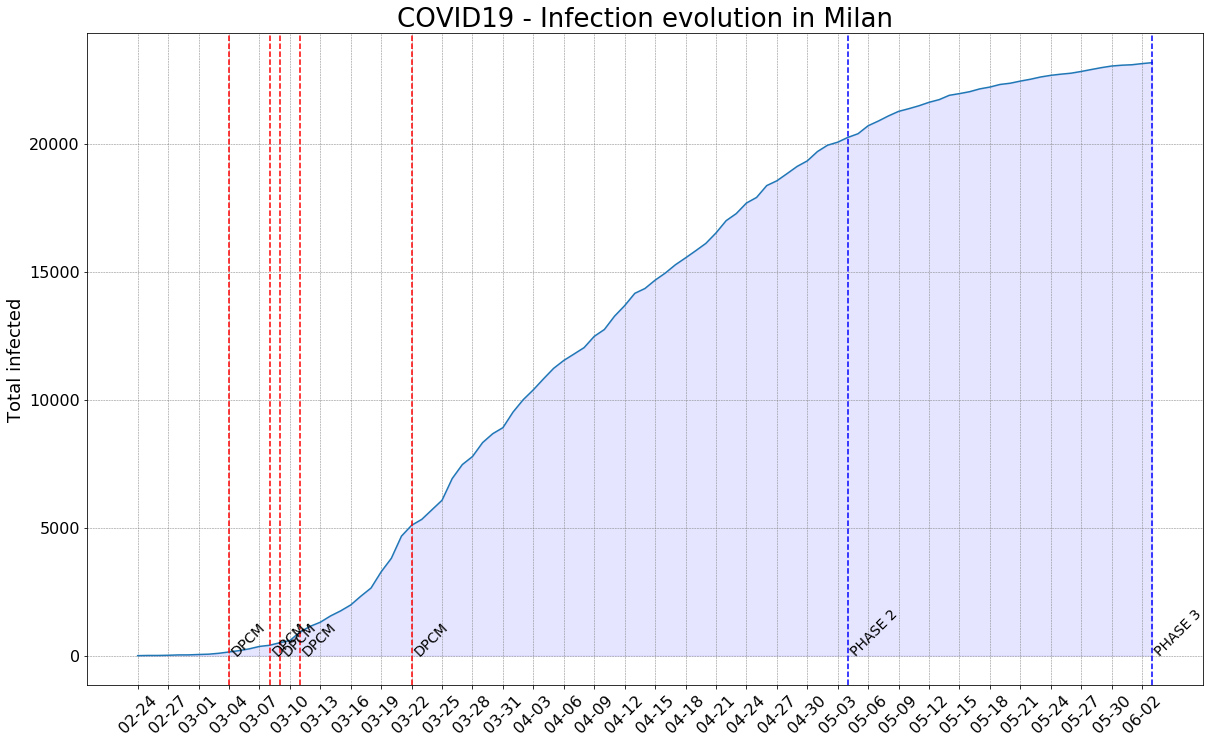

In [9]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_casi",
                  data=df_mln)
plt.fill_between(x='reference_day', y1='totale_casi', y2=0 ,data=df_mln, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Total infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection evolution in Milan', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/infection_evolution_mln.png")
plt.show()

In [10]:
def get_trend(series):
    from pandas import datetime
    from sklearn.linear_model import LinearRegression
    from matplotlib import pyplot
    import numpy
     
    def parser(x):
        return datetime.strptime('190'+x, '%Y-%m')
     
    series = series.dropna()
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = numpy.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


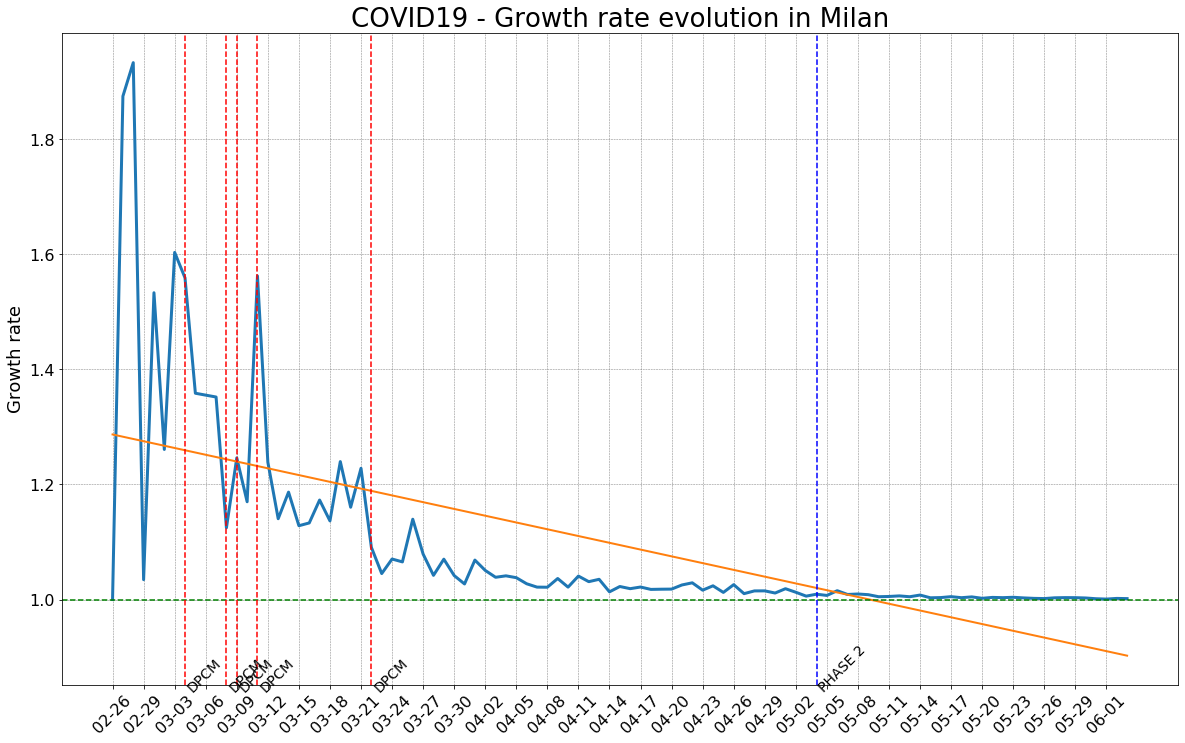

In [11]:
# Generate plot
df_gr = df_mln[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr = df_mln[["reference_day", "growth_rate"]].dropna().copy()
df_gr = df_gr.iloc[1:,:].copy()
df_gr["trend"] = get_trend(df_gr["growth_rate"])
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="growth_rate",
                  data=df_gr, lw=3)
ax = sns.lineplot(x="reference_day", y="trend",
                  data=df_gr, lw=2)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Growth rate', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Growth rate evolution in Milan', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
#plt.ylim(bottom=-2, top=5)
ax.axhline(1, ls='--', color='green', lw=1.5)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .84,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .84,'PHASE 2', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/growth_rate_mln.png")
plt.show()

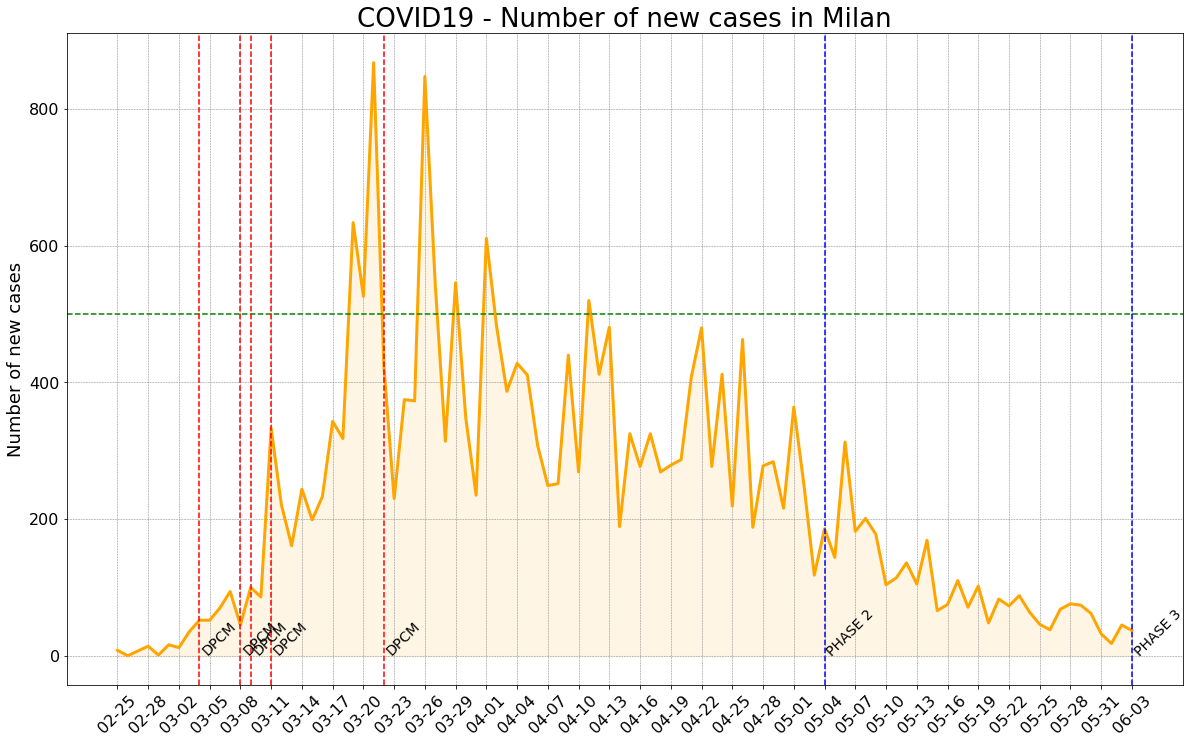

In [12]:
# Focus on number of new cases
df_pl = df_mln.copy()
df_pl.sort_values(by=["reference_day"], ascending=True, inplace=True)

plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="nuovi_casi",
                  data=df_pl, lw=3, color='orange')
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.fill_between(x='reference_day', y1='nuovi_casi', y2=0 ,data=df_pl, color='orange', alpha=.1)
plt.ylabel('Number of new cases', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Number of new cases in Milan', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
ax.axhline(500, ls='--', color='green', lw=1.5)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .5,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.savefig(f"{dir_path}/new_cases_evolution_.png")
plt.show()